# Introduction

The following data set is a first template for a classification of the RAR Feature (Readmission Rate). I did not further plot the individual features or their relationsship to each other as this is not the scope of this notebook. Some work regarding an EDA was already provided by @mpwolke.

With this notebook I wanted to deliver a first template for a classification of the RAR feature. 
To achieve some good results I used a MLPClassifier as well as a Random Forest Classifier and performed a Random Gridsearch for hyperparameter tuning.

Most of the work here went in the feature engineering of the free text Diagnosis feature which in my opinion can be one of the key indicators for the RAR feature.

Feel free to comment on my work so that I and you can learn something from this. 

I hope you have fun reading this notebook. 

Cheers Dominik


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Dataset.csv',delimiter=',')

# random forest classifier
df.head(2)

,ID,GENDER,AGE,RACE/ETHNICITY,Diagnosis,MD,Assignment,EMR,LOS,RAR,...,X,Y,Z,AA,AB,AC,AD,# Psychotropic Medications,# Administrations,Therapeutic Guidances
0,1,F,49,W,"MDD, Recurrent, Unspecified",L,G,C,70,0,...,0,0,0,0,1,0,0,3,6,EG
1,2,F,21,W,"MDD, Recurrent, Unspecified",A,G,C,309,0,...,0,13,0,0,0,0,0,3,27,CT


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          1500 non-null   int64 
 1   GENDER                      1500 non-null   object
 2   AGE                         1500 non-null   int64 
 3   RACE/ETHNICITY              1500 non-null   object
 4   Diagnosis                   1500 non-null   object
 5   MD                          1500 non-null   object
 6   Assignment                  1459 non-null   object
 7   EMR                         1500 non-null   object
 8   LOS                         1500 non-null   int64 
 9   RAR                         1500 non-null   int64 
 10  A                           1500 non-null   int64 
 11  B                           1500 non-null   int64 
 12  C                           1500 non-null   int64 
 13  D                           1500 non-null   int6

In [3]:
df.columns

Index(['ID', 'GENDER', 'AGE', 'RACE/ETHNICITY', 'Diagnosis', 'MD',
       'Assignment', 'EMR', 'LOS', 'RAR', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
       'V', 'W', 'X', 'Y', 'Z', 'AA', 'AB', 'AC', 'AD',
       '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances'],
      dtype='object')

In [4]:

# los is in hours lets convert it to full days
df.LOS = df.LOS.apply(lambda x: round(x/24,0))

In [5]:
# target feature is the readmission flag
# most patients did not get readmitted
# 1358 patients did not get readmitted while 142 patients did
df.RAR.value_counts()

0    1358
1     142
Name: RAR, dtype: int64

In [6]:
# cast the values to categorical values and substitute them with dummy numerical values
df["GENDER"] = df["GENDER"].astype('category').cat.codes
df["RACE/ETHNICITY"] = df["RACE/ETHNICITY"].astype('category').cat.codes
df['MD'] = df['MD'].astype('category').cat.codes
df['Assignment'] = df['Assignment'].astype('category').cat.codes
df['EMR'] = df['EMR'].astype('category').cat.codes
df['Therapeutic Guidances'] = df['Therapeutic Guidances'].astype('category').cat.codes


In [7]:
df.head(2)

,ID,GENDER,AGE,RACE/ETHNICITY,Diagnosis,MD,Assignment,EMR,LOS,RAR,...,X,Y,Z,AA,AB,AC,AD,# Psychotropic Medications,# Administrations,Therapeutic Guidances
0,1,0,49,3,"MDD, Recurrent, Unspecified",11,0,0,3.0,0,...,0,0,0,0,1,0,0,3,6,1
1,2,0,21,3,"MDD, Recurrent, Unspecified",0,0,0,13.0,0,...,0,13,0,0,0,0,0,3,27,0


In [8]:
# take a look at the Diagnosis column
# here we can see that we can combine some diagnosis together 
# also the frequency and severity of the illness is kept in this text field
df.Diagnosis.value_counts()

MDD, Recurrent, Severe Without Psychotic Features                                    320
Depressive Disorder NOS                                                              265
MDD, Recurrent, Unspecified                                                          243
MDD, Single Episode,Severe Without Psychotic Features                                238
MDD                                                                                  115
MDD, Single Episode, Severe With Psychotic Features                                  114
MDD, Recurrent, Severe With Psychotic Features                                        84
MDD, Single Episode, Unspecified                                                      26
MDD, Recurrent, Moderate                                                              16
\tMDD, recurrent episode with anxious distress                                        16
MDD, Recurrent, Chronic                                                               13
MDD, recurrent, sever

# **Diagnosis Feature Engineering**

**A key feature of the data set is the free text Diagnosis column. In order to make sense of this feature I clustered some diagnosis together and created new features indicating the**
1. diagnosis_type -> which states the main diagnosis given
2. frequency      -> which states the frequency the illness appears
3. severity       -> which states the severity of the illness
4. features       -> special "features" of the illness e.g. anxiety or psychotic features

In [9]:
# put similar diagnosis types together
# diagnosis_type -> states the main diagnosis given
# frequency      -> states the frequency the illness appears
# severity       -> states the severity of the illness
# features       -> special "features" of the illness e.g. anxiety or psychotic features

for idx,row in df.iterrows():
    if row["Diagnosis"] == "MDD, Recurrent, Severe Without Psychotic Features":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "severe"
        df.loc[idx,"features"] = None
    elif row["Diagnosis"] == "Depressive Disorder NOS":
        df.loc[idx,"diagnosis_type"] = "depression"
    elif row["Diagnosis"] == "MDD, Recurrent, Unspecified":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
    elif row["Diagnosis"] == "MDD, Single Episode,Severe Without Psychotic Features":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "single"
        df.loc[idx,"severity"] = "severe"
        df.loc[idx,"features"] = None
    elif row["Diagnosis"] == "MDD" or row["Diagnosis"] == "Unspecified Depressive Disorder" or row["Diagnosis"] == "Major depression, melancholic type":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
    elif row["Diagnosis"]=="row MDD, Single Episode, Severe With Psychotic Features":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "single"
        df.loc[idx,"severity"] = "severe"
        df.loc[idx,"features"] = "psychotic"
    elif row["Diagnosis"] == "MDD, Recurrent, Severe With Psychotic Features" \
        or row["Diagnosis"] == "Major depressive disorder, recurrent episode, severe, with psychosis":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "severe"
        df.loc[idx,"features"] = "psychotic"
    elif row["Diagnosis"] == "MDD, Single Episode, Unspecified":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "single"
    elif row["Diagnosis"] == "MDD, Recurrent, Moderate":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "moderate"
    elif row["Diagnosis"] == "MDD, Recurrent, Chronic":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "chronic"
    elif row["Diagnosis"] == "MDD, recurrent, severe":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "severe"
    elif row["Diagnosis"] == "Severe episode of recurrent major depressive disorder, without psychotic features":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "severe"
        df.loc[idx,"features"] = None
    elif row["Diagnosis"] == "MDD, Single Episode, Moderate":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "single"
        df.loc[idx,"severity"] = "moderate"
    elif row["Diagnosis"] == "\tDepression, unspecified type ":
        df.loc[idx,"diagnosis_type"] = "depression"
    elif row["Diagnosis"] == "MDD, Recurrent, Mild":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "mild"
    elif row["Diagnosis"] == "MDD, Single Episode, Mild":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "single"
        df.loc[idx,"severity"] = "mild"
    elif row["Diagnosis"] == "MDD, recurrent episodes":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
    elif row["Diagnosis"] == "Depression with suicidal ideation":
        df.loc[idx,"diagnosis_type"] = "depression"
        df.loc[idx,"severity"] = "severe"
    elif row["Diagnosis"] == "Bipolar II Disorder":
        df.loc[idx,"diagnosis_type"] = "bipolar_disorder"
    elif row["Diagnosis"] == "Mood Disorder NOS":
        df.loc[idx,"diagnosis_type"] = "mood_disorder"
    elif row["Diagnosis"] == "Major depressive disorder, recurrent episode with anxious distress" or row["Diagnosis"] == "\tMDD, recurrent episode with anxious distress":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"features"] = "anxiety"
    elif row["Diagnosis"] == "MDD, single episode with psychotic features, mood-conguent":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "single"
        df.loc[idx,"features"] = "psychotic"
    elif row["Diagnosis"] == "Adjustment Disorder With Depressed Mood":
        df.loc[idx,"diagnosis_type"] = "adjustment_disorder"
    elif row["Diagnosis"] == "Major depressive disorder, recurrent, with postpartum onset":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
    elif row["Diagnosis"] == "MDD, recurrent, severe with atypical features":
        df.loc[idx,"diagnosis_type"] = "major_depressive_disorder"
        df.loc[idx,"frequency"] = "recurrent"
        df.loc[idx,"severity"] = "severe"
        df.loc[idx,"features"] = "atypical"
    elif row["Diagnosis"] == "Schizoaffective Disorder":
        df.loc[idx,"diagnosis_type"] = "schizoaffective_disorder"
    elif row["Diagnosis"] == "Dissociative Disorder":
        df.loc[idx,"diagnosis_type"] = "dissociative_disorder"

print("Count of unique diagnosis: ")
print(df.diagnosis_type.value_counts(dropna=False))
print("")
print("Count of frequencies: ")
print(df.frequency.value_counts(dropna=False))
print("")
print("Count of severity stages: ")
print(df.severity.value_counts(dropna=False))
print("")
print("Count of features: ")
print(df.features.value_counts(dropna=False))


Count of unique diagnosis: 
major_depressive_disorder    1104
depression                    267
NaN                           125
mood_disorder                   1
schizoaffective_disorder        1
adjustment_disorder             1
bipolar_disorder                1
Name: diagnosis_type, dtype: int64

Count of frequencies: 
recurrent    715
NaN          513
single       272
Name: frequency, dtype: int64

Count of severity stages: 
NaN         801
severe      661
moderate     21
chronic      13
mild          4
Name: severity, dtype: int64

Count of features: 
NaN          1396
psychotic      86
anxiety        17
atypical        1
Name: features, dtype: int64


In [10]:
# cast the values to categorical values and substitute them with dummy numerical values
df['diagnosis_type'] = df['diagnosis_type'].astype('category').cat.codes
df['frequency'] = df['frequency'].astype('category').cat.codes
df['severity'] = df['severity'].astype('category').cat.codes
df['features'] = df['features'].astype('category').cat.codes

In [11]:
# drop the Diagnosis and ID columns as the have no value for the prediction
df.drop(["Diagnosis","ID"], axis=1, inplace=True)

In [12]:
# columns in the current data set
df.columns

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'MD', 'Assignment', 'EMR', 'LOS',
       'RAR', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA',
       'AB', 'AC', 'AD', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances', 'diagnosis_type', 'frequency', 'severity',
       'features'],
      dtype='object')

In [13]:
# split the data in train and test set
from sklearn.model_selection import train_test_split

X=df.drop(columns="RAR")
y=df["RAR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)


# use ADASYN for oversampling of the minority class 1 (people who did not get readmitted) of the training data
# ONLY USE THESE TECHNIQUES FOR THE TRAINING DATA IF YOU WANT TO PREVENT DATA LEAKAGE
from imblearn.over_sampling import ADASYN

smt = ADASYN(random_state=0) 
X_train, y_train = smt.fit_resample(X_train, y_train)



In [14]:
# take a look at new data distribution
# both classes are now evenly distributed
y_train.value_counts()

1    1088
0    1081
Name: RAR, dtype: int64

In [15]:
# we have 1200 observations in the training set and 300 in the test set
X_train.shape, y_train.shape

((2169, 44), (2169,))

# Multi Layer Perceptron Classifier

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# define parameter space
max_iter = np.arange(100, 3000, step=500)

parameter_space = {
    'hidden_layer_sizes': [(20,),(128,64,32,16,4), (64,32,16,8,4), (32,16,8,4,2), (16,8,4,2,1), (100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.05,1, 2],
    'learning_rate': ['constant','adaptive'],
    'max_iter': max_iter
}

# define model
model = MLPClassifier(random_state=0)

clf = RandomizedSearchCV(model, parameter_space, n_jobs=-1, cv=3, verbose=1, scoring="f1")
clf.fit(X_train, y_train)

# get best hyperparameter combination - best estimator
print(clf.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
model = clf.best_estimator_

y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       277
           1       0.03      0.04      0.03        23

    accuracy                           0.81       300
   macro avg       0.47      0.46      0.47       300
weighted avg       0.85      0.81      0.83       300



In [ ]:
print(df.columns)

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'MD', 'Assignment', 'EMR', 'LOS',
       'RAR', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA',
       'AB', 'AC', 'AD', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances', 'diagnosis_type', 'frequency', 'severity',
       'features'],
      dtype='object')


# Random Forest Classifier

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# define parameter space that is to be searched
n_estimators = np.arange(100, 2000, step=100)
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(10, 100, step=10)) + [None]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

parameter_space = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

model = RandomForestClassifier(random_state=0)

clf = RandomizedSearchCV(model, parameter_space, n_jobs=-1, cv=3, scoring="f1")
clf.fit(X_train, y_train)

# get best hyperparameter combination - best estimator
print(clf.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=80, max_features='log2',
                       min_samples_split=6, n_estimators=1400, random_state=0)


In [ ]:
model = clf.best_estimator_

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       277
           1       0.25      0.04      0.07        23

    accuracy                           0.92       300
   macro avg       0.59      0.52      0.52       300
weighted avg       0.87      0.92      0.89       300



<AxesSubplot:>

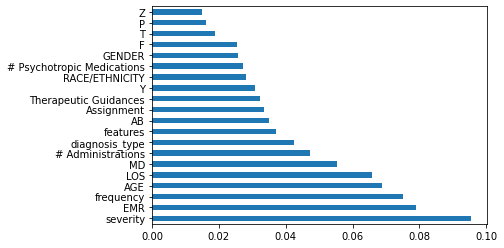

In [ ]:

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Conclusion

**apparently the age, medication AB are good indicators for the 
 however, the number of Administrations (medication given) is the by far the most important predictor**